# Building networks

For the industry benchmark systems we provide the ligands with different sets of partial charges along with LOMAP networks generated with Kartograf atom mappings, this notebook then combines the two to make an `AlchemicalNetwork` ready for simulation.

Note this assumes you are using a protocol which runs a bond and solvent leg as two different transformations.

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
import openfe
from openfe_benchmarks.data import get_benchmark_data_system

In [2]:
# declare the charge settings and the system you want to generate the network for
CHARGE_MODEL = "antechamber_am1bcc" 
SYSTEM_GROUP = "industry_benchmark_systems.jacs_set"
SYSTEM_NAME = "tyk2"

In [3]:
# define the protocol to use
settings = openfe.protocols.openmm_rfe.RelativeHybridTopologyProtocol.default_settings()
settings.protocol_repeats = 1
protocol = openfe.protocols.openmm_rfe.RelativeHybridTopologyProtocol(settings=settings)

In [4]:
# find the system
system = get_benchmark_data_system(SYSTEM_GROUP, SYSTEM_NAME)

# load the network 
network = openfe.LigandNetwork.from_json(file=str(system.network))

# load the ligands with charges
supplier = Chem.SDMolSupplier(str(system.ligands[CHARGE_MODEL]), removeHs=False)
ligands_by_name = {}
for mol in supplier:
    ofe_mol = openfe.SmallMoleculeComponent.from_rdkit(mol)
    ligands_by_name[ofe_mol.name] = ofe_mol

# load the protein
protein = openfe.ProteinComponent.from_pdb_file(str(system.protein))

# check for cofactors
cofactors = []
if system.cofactors:
    supplier = Chem.SDMolSupplier(str(system.cofactors[CHARGE_MODEL]), removeHs=False)
    for mol in supplier:
        cofactors.append(openfe.SmallMoleculeComponent.from_rdkit(mol))

# define the standard solvent
solvent = openfe.SolventComponent()

2026-01-29 15:00:05 | INFO     | Loaded system 'tyk2' from benchmark set 'industry_benchmark_systems.jacs_set' with 5 ligand file(s), and 0 cofactor file(s). Found network file: False; Found protein file: False.


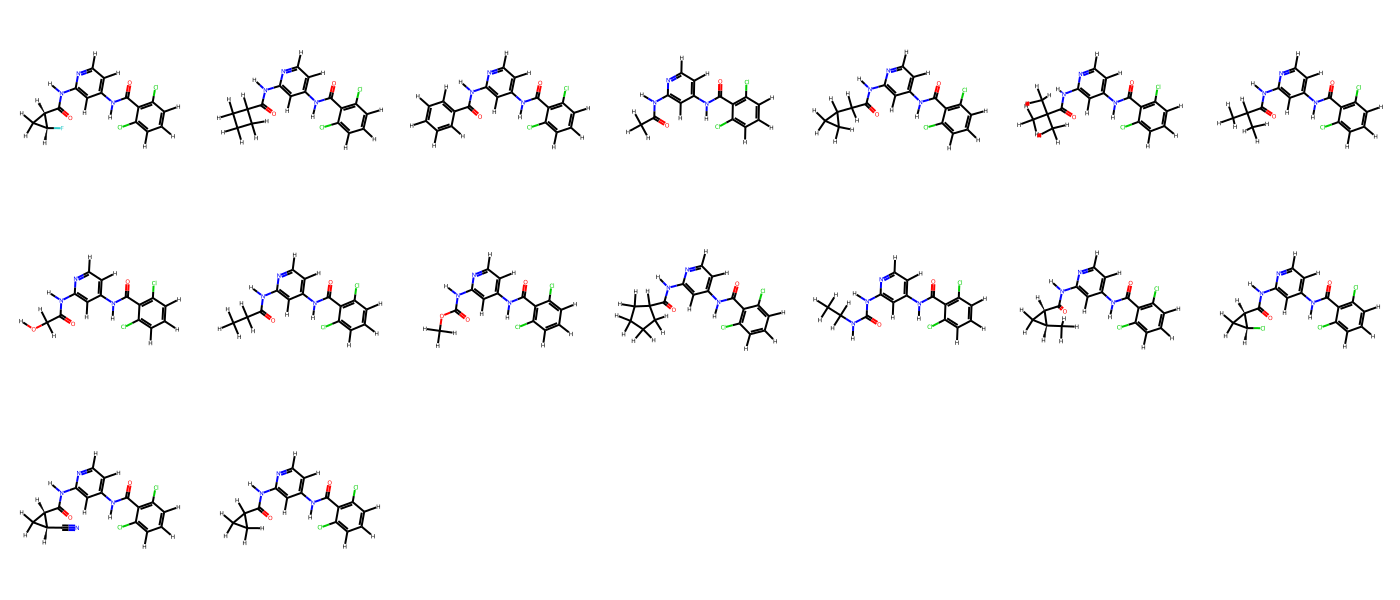

In [5]:
# View ligands in a Jupyter notebook with RDKit:

# Load ligands from SDF file
ligand_rdmols = [m for m in Chem.SDMolSupplier(system.ligands["nagl_openff-gnn-am1bcc-1.0.0.pt"], removeHs=False)]

# Generate 2D coordinates for visualization
[AllChem.Compute2DCoords(ligand) for ligand in ligand_rdmols]

# Display as grid
Chem.Draw.MolsToGridImage(ligand_rdmols, molsPerRow=7)

In [6]:
# build the transforms
transformations = []
for edge in network.edges:
    # make the edge again using ligands with charges
    new_edge = openfe.LigandAtomMapping(
        componentA=ligands_by_name[edge.componentA.name],
        componentB=ligands_by_name[edge.componentB.name], 
        componentA_to_componentB=edge.componentA_to_componentB,
        annotations=edge.annotations,
    )

    # create the transformations for the bound and solvent legs
    for leg in ["solvent", "complex"]:
        system_a_dict = {
            "ligand": new_edge.componentA, "solvent": solvent
        }
        system_b_dict = {
            "ligand": new_edge.componentB, "solvent": solvent
        }
        if leg == "complex":
            system_a_dict["protein"] = protein
            system_b_dict["protein"] = protein

            if cofactors:
                for i, cofactor in enumerate(cofactors):
                    cofactor_name = f"cofactor_{i}"
                    system_a_dict[cofactor_name] = cofactor
                    system_b_dict[cofactor_name] = cofactor

        system_a = openfe.ChemicalSystem(system_a_dict)
        system_b = openfe.ChemicalSystem(system_b_dict)

        name = f"{leg}_{new_edge.componentA.name}_{new_edge.componentB.name}"
        transformation = openfe.Transformation(
            stateA=system_a,
            stateB=system_b,
            mapping=new_edge,
            protocol=protocol,
            name=name
        )
        transformations.append(transformation)

# create the network, profit! 
alchemical_network = openfe.AlchemicalNetwork(edges=transformations)

In [7]:
alchemical_network.__dict__

{'_edges': frozenset({Transformation(stateA=ChemicalSystem(name=, components={'ligand': SmallMoleculeComponent(name=jmc_30), 'solvent': SolventComponent(name=O, Na+, Cl-), 'protein': ProteinComponent(name=)}), stateB=ChemicalSystem(name=, components={'ligand': SmallMoleculeComponent(name=ejm_46), 'solvent': SolventComponent(name=O, Na+, Cl-), 'protein': ProteinComponent(name=)}), protocol=<RelativeHybridTopologyProtocol-10f35f2039e724196510ff5c0cdf4026>, name=complex_jmc_30_ejm_46),
            Transformation(stateA=ChemicalSystem(name=, components={'ligand': SmallMoleculeComponent(name=ejm_31), 'solvent': SolventComponent(name=O, Na+, Cl-), 'protein': ProteinComponent(name=)}), stateB=ChemicalSystem(name=, components={'ligand': SmallMoleculeComponent(name=ejm_45), 'solvent': SolventComponent(name=O, Na+, Cl-), 'protein': ProteinComponent(name=)}), protocol=<RelativeHybridTopologyProtocol-10f35f2039e724196510ff5c0cdf4026>, name=complex_ejm_31_ejm_45),
            Transformation(stateA=